In [5]:
from postgresql_storage import PostgresStorage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [3]:
storage = PostgresStorage()

df = pd.read_sql(storage.get_all_to_df().statement,
                 storage.session.bind).drop_duplicates().set_index('date')

df = pd.pivot_table(
        df, index=df.index, columns='code', values='value')

2020-12-07 11:15:29,418 INFO sqlalchemy.engine.base.Engine select version()
2020-12-07 11:15:29,419 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 11:15:29,420 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-12-07 11:15:29,421 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 11:15:29,422 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-07 11:15:29,423 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 11:15:29,424 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-07 11:15:29,425 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 11:15:29,426 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-12-07 11:15:29,426 INFO sqlalchemy.engine.base.Engine {}
2020-12-07 11:15:29,428 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

In [4]:
df.head()

code,AUD,BGN,BRL,CAD,CHF,CNY,DKK,EUR,GBP,HKD,...,PLN,RON,RUB,SEK,SGD,THB,TRY,USD,XDR,ZAR
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,15.873,12.991,5.664,17.461000,23.388000,3.260,3.401,25.410000,29.955000,2.914,...,5.972,5.314,0.36716,2.426,16.844999,0.75296,3.810,22.702000,31.393000,1.613
2020-01-03,15.821,12.968,5.599,17.530001,23.396000,3.264,3.393,25.360001,29.797001,2.925,...,5.968,5.306,0.36690,2.418,16.857000,0.75452,3.809,22.753000,31.490000,1.593
2020-01-06,15.696,12.935,5.566,17.413000,23.316999,3.243,3.385,25.299999,29.687000,2.909,...,5.965,5.299,0.36452,2.402,16.743999,0.74963,3.782,22.601000,31.219000,1.586
2020-01-07,15.553,12.921,5.541,17.408001,23.299000,3.259,3.382,25.275000,29.674999,2.911,...,5.954,5.289,0.36507,2.397,16.761000,0.74726,3.786,22.625999,31.336000,1.583
2020-01-08,15.603,12.923,5.604,17.464001,23.406000,3.275,3.381,25.264999,29.778000,2.924,...,5.955,5.288,0.36821,2.403,16.834000,0.74892,3.820,22.739000,31.478001,1.598


0.003354948745763348


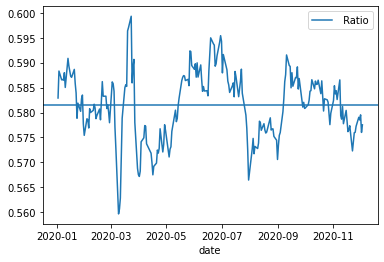

In [41]:
C1 = df['CAD']
C2 = df['GBP']
score, pvalue, _ = coint(C1, C2)
print(pvalue)
ratios = C1 / C2
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

In [42]:
def zscore(series):
    return (series - series.mean()) / series.std()

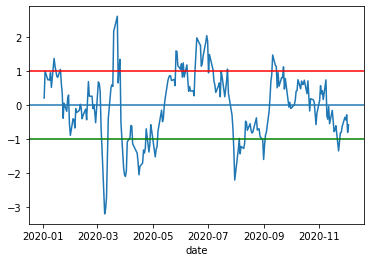

In [43]:
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [44]:
ratios = C1 / C2
samples = len(ratios)
print(samples)
train = ratios[:int(samples*0.7)]
test = ratios[int(samples*0.7):]

234


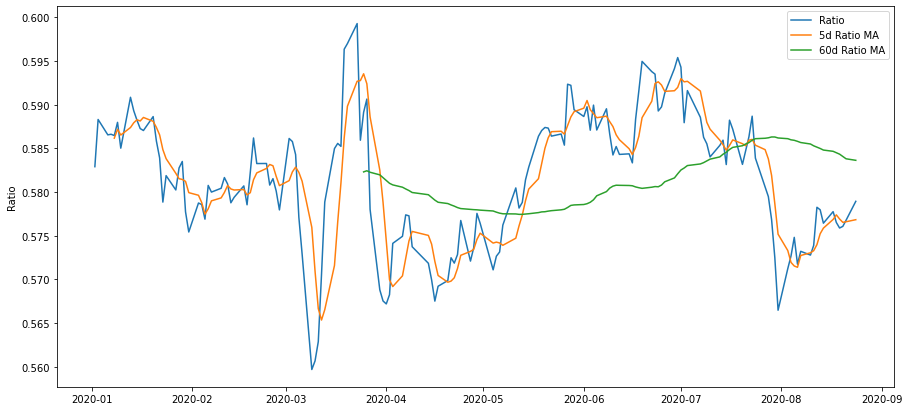

In [45]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60) / std_60

plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

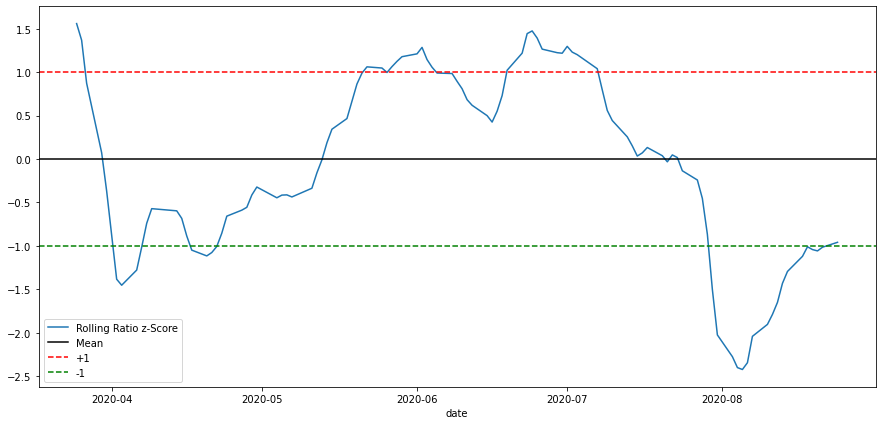

In [46]:
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

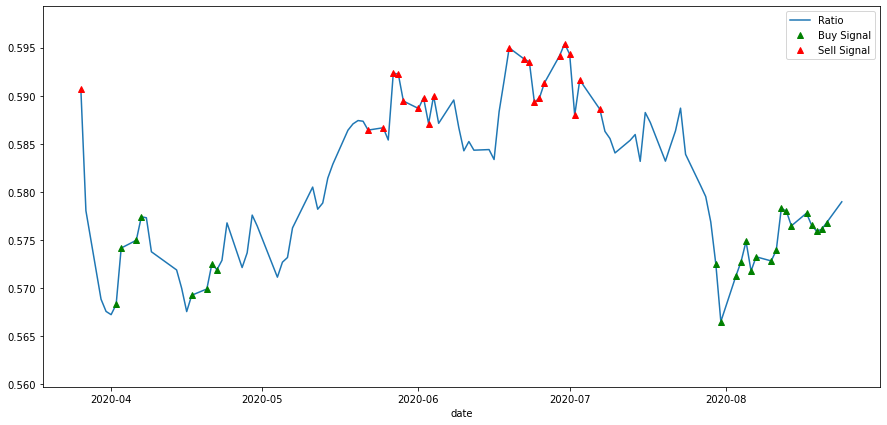

In [47]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
train[60:].plot()

buy = train.copy()
sell = train.copy()

buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0

buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')

x1,x2,y1,y2 = plt.axis()

plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()